# Kinetics IV

Today, we'll discuss analysis of kinetic data obtained in a CSTR.  We'll consider the impacts of measurement error and how it can be managed, and we'll also discuss how to work with a maddening set of data that were not obtained very systematically...

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
from math import ceil, floor

## Example Problem 01

Analysis of Data obtained in a CSTR

The following reaction is carried out in a 0.275L CSTR at steady state.  The experiment is performed by varying the inlet volumetric flowrate (Q$_f$) of a solution that always has a concentration $C_{A_f}$ = 10 mol L$^{-1}$.  You may assume the fluid density is constant so that $Q = Q_f$.

$$A \longrightarrow B$$

You measure the concentration of species A and species B in the effluent stream from the reactor.  The data are compiled in the table below. For now, we'll look at essentially perfect data just to get a feel for the way that we handle the analysis without also dealing with precision and measurement uncertainty.

|**Q$_f$ (L/sec)** | **C$_A$ (mol/L)** | **C$_B$ (mol/L)** |
|:----------------:|:-----------------:|:-----------------:|
|2.750             | 9.98              | 2.29 x 10$^{-2}$  |
|5.500 x 10$^{-1}$ | 9.89              | 1.14 x 10$^{-1}$  |
|3.667 x 10$^{-1}$ | 9.83              | 1.70 x 10$^{-1}$  |
|2.750 x 10$^{-1}$ | 9.78              | 2.25 x 10$^{-1}$  |
|1.375 x 10$^{-1}$ | 9.56              | 4.40 x 10$^{-1}$  |
|5.500 x 10$^{-2}$ | 8.97              | 1.03              |
|2.750 x 10$^{-2}$ | 8.13              | 1.87              |
|1.833 x 10$^{-2}$ | 7.43              | 2.57              |
|1.375 x 10$^{-2}$ | 6.85              | 3.15              |
|5.500 x 10$^{-3}$ | 4.65              | 5.35              |
|2.750 x 10$^{-3}$ | 3.03              | 6.97              |

Assuming the reaction rate is described by power law kinetics,

$$r = kC_A^{\alpha}$$ 

where $\alpha$ is an integer, use the measured concentrations of A in the reactor effluent to determine the reaction order in A and the rate constant for this reaction.

### Solution to Example Problem 01

Let's stick with our conventional wisdom that, if we want to determine the reaction order with respect to A, we need to know how the rate of reaction changes in response to the concentration of species A.  This is easiest to do if everything else is constant.  Fortunately, these reactions are performed at constant temperature and in a solvent, so the fluid density is constant.  Also, we know from the problem statement that the rate of reaction ***does not*** depend on B.  This allows us to focus on how changing the concentration of A will impact the rate of reaction.

#### Estimation of reaction rates in a CSTR at Steady State

As with a batch reactor, the starting point for this analysis is a material balance.  We'll choose to work with a balance on A. The problem statement requests information about the order in A, so this is a sensible approach.

For a CSTR at steady state:

$$0 = F_{A,f} - F_{A} + R_AV$$

We are given data about concentrations and volumetric flowrates, so I'll recast this balance in terms of those parameters:

$$0 = C_{A,f}Q_f - C_AQ_f + R_AV$$

Dividing through by the feed volumetric flowrate, we get:

$$0 = C_{A,f} - C_A + R_A\tau$$

Finally, recognizing that we have a single reaction here, we can make the substitution that $R_A = -r$:

$$0 = C_{A,f} - C_A - r\tau$$

And we can solve that balance for r to get:

$$r = \frac{C_{A,f} - C_A}{\tau}$$

Interesting -- in a CSTR, dividing $\Delta C_A$ by $\Delta \tau$ gives us a direct calculation of reaction rate at the concentration inside of the CSTR (rather than a finite difference approximation like in a batch reactor).  That seems promising...

Once we have a reaction rate calculated, it reflects the conditions inside the CSTR, which is a well-mixed reactor.  That means that solving this equation for each experimental condition will give us a set of reaction rates measured at various concentrations of A.  

#### Analysis of Perfect Data

First, we'll analyze the data set that I generated by solving the material balance for known kinetics.

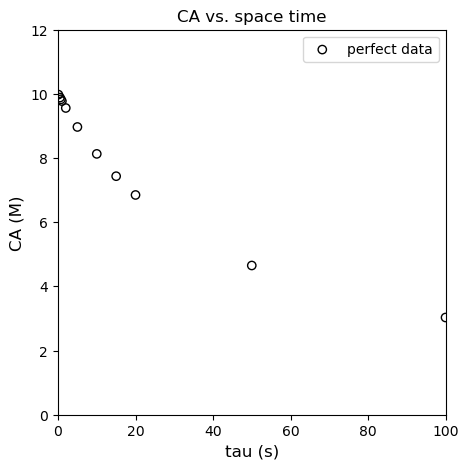

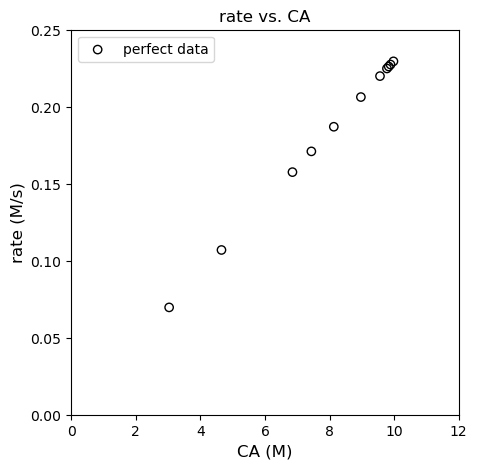

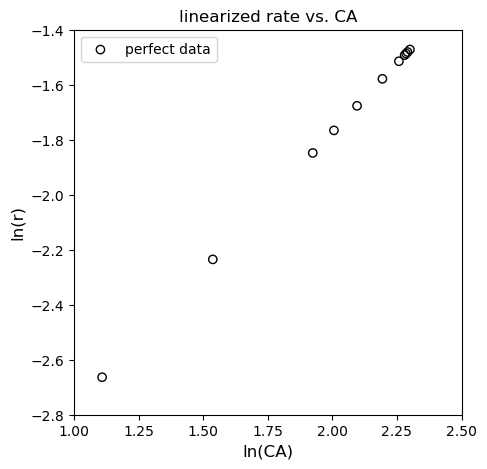

In [33]:
V      = 0.275 #L
CAf    = 10    #mol/L
Qftrue = np.array([2.7500000000, 0.5500000000, 0.3666666667, 0.2750000000, 0.1375000000, 0.0550000000, 0.0275000000, 0.0183333333, 0.0137500000, 0.0055000000, 0.0027500000]) #L/sec
CAtrue = np.array([9.9770527786, 9.8863074642, 9.8304251659, 9.7751710655, 9.5602294455, 8.9686098655, 8.1300813008, 7.4349442379, 6.8493150685, 4.6511627907, 3.0303030303]) #mol/L
τtrue  = V/Qftrue
rtrue  = (CAf - CAtrue)/τtrue

plt.figure(figsize = (5, 5))
plt.scatter(τtrue, CAtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.xlabel('tau (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.title('CA vs. space time')
plt.xlim(0, 100)
plt.ylim(0, 12)
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(CAtrue, rtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.xlabel('CA (M)', fontsize = 12)
plt.ylabel('rate (M/s)', fontsize = 12)
plt.title('rate vs. CA')
plt.xlim(0, 12)
plt.ylim(0, 0.25)
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(np.log(CAtrue), np.log(rtrue), marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.xlabel('ln(CA)', fontsize = 12)
plt.ylabel('ln(r)', fontsize = 12)
plt.title('linearized rate vs. CA')
plt.xlim(1.0, 2.5)
plt.xticks(np.arange(1.0, 2.51, 0.25))
plt.ylim(-2.8, -1.4)
plt.legend()
plt.show()

#### Assessing linearity in rate data

Well, that looks linear, suggesting we have power law kinetics, though the reaction order is unknown currently.  We can estimate the reaction order and the rate constant by linear regression, which I implemented below using standard matrix notation that would be in your statistics textbook from CEN 212.  As a refresher, we're solving this problem:

$$XA = Y$$

Where X is the truncated Vandermonde matrix up to whatever order we're considering (here, it is up to first order).  A is the matrix of polynomial coefficients.  Here it is of length 2 because we are fitting a first order equation to the data, so, the slope of the line is given by A[0], and the y-intercept is given by A[1]. Y is a vector of our measurements.

In our linearized model, our "X" values are given by ln(CA), and our Y values are given by ln(r).

The X matrix is "tall" here.  It has 6 rows (because we made six measurements), but only 2 columns (because we only have a first order model with two coefficients).  The Y vector is a 6x1 column.  This system is overdetermined, and there is no single line that will pass through all data points.  There is however a unique least squares solution that gives the line that models all data points with minimum residual error.  That is given by:

$$\hat{A} = (X^\prime X)^{-1}X^\prime Y$$

Which, in numpy would be solved either as:

```python
A = np.linalg.solve(X.T@X, X.T@Y)
```

Or the convenience least squares solution in numpy:

```python
A = np.linalg.lstsq(X, Y)
```

I use the first one because I just do all the linear regression calculations and definitions manually. We calculate the residual sum of squares as usual:

$$SSE = \sum_i (y_i - \hat{y}_i)^2$$

Which, for a linear regression problem is equivalent to:

$$SSE = (Y - XA)'(Y - XA)$$

In numpy that would be:

```python
SSE = (Y - X@A).T@(Y - X@A)
```

The total sum of squares quantifies the error between the measurement and the mean of measurments:

$$SST = \sum_i (y_i - \bar{y}_i)$$

If we have the residual and total sum of squares, we can calculate the coefficient of determination:

$$R^2 = 1 - \frac{SSE}{SST}$$

If you want to obtain estimates of standard error in the slope and y intercept that you regress, you need to estimate the covariance matrix.  First, we estimate the variance, $\sigma^2$ with the following:

$$\sigma^2 \approx s^2$$

and:

$$s^2 = \frac{SSE}{n_m - n_p}$$

Where $n_m$ is the number of measurements and $n_p$ is the number of regressed parameters.  This is also known as the "degrees of freedom" in our regression.

$$s^2 = \frac{SSE}{DOF}$$

With that, we can estimate the covariance matrix from the measured data:

$$COV = s^2(X'X)^{-1}$$

The standard error in our regressed parameters is given by the diagonal elements in the following matrix:

$$se = \sqrt{COV}$$

From that, we get the standard error in the slope from se[0,0] and the standard error in the intercept from se[1,1], i.e., the diagonal elements.

If you want to calculate confidence intervals, they are given by:

$$CI = t(q, DOF)\times SE$$

Finally, noting that I'm working with a linear system, if I want to generate predicted values of my measured quantity (here ln(CA)), I can do so by multiplying my truncated vandermonde matrix by the regressed coefficients:

$$\hat{Y} = X\hat{A}$$

m    =  1.00e+00 +/- 1.13e-09
b    = -3.77e+00 +/- 2.32e-09
SSE  =      0.00
SST  =      1.46
MSE  =      0.00
RMSE =      0.00
R2   =      1.00
α    =  1.00e+00 +/- 1.13e-09
k    =  2.30e-02 (but is between 2.30e-02 and 2.30e-02)


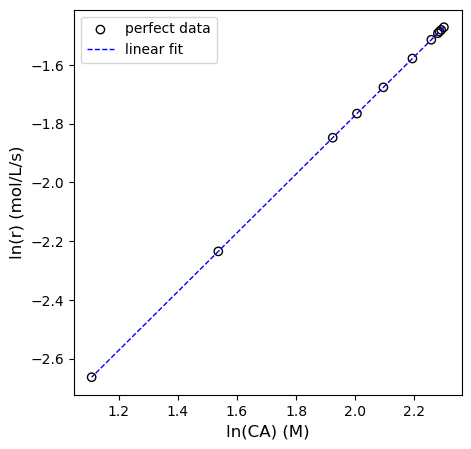

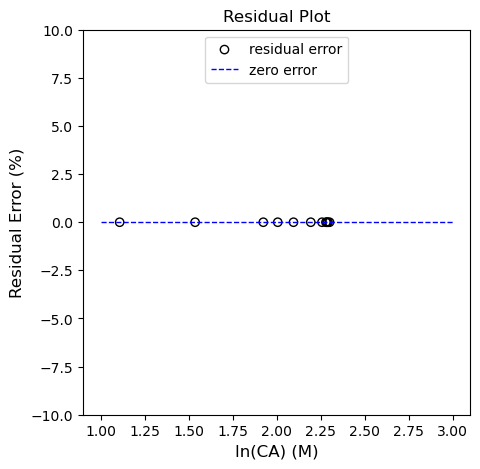

In [34]:
xdata = np.log(CAtrue)
ydata = np.log(rtrue)

X     = np.vander(xdata, 2)#This creates the X matrix shown above, truncating at 1st order
Y     = ydata    
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                #slope of best fit line
b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
CIb   = SEb*tval              #95% confidence interval on y-intercept
α     = m
k     = np.exp(b)
labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2, α, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2e} +/- {CIb:8.2e}')
    elif label == 'α':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:9.2e} (but is between {np.exp(b-CIb):8.2e} and {np.exp(b+CIb):8.2e})')
    else:
        print(f'{label:4s} = {value:9.2f}')
        
plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('ln(CA) (M)', fontsize = 12)
plt.ylabel('ln(r) (mol/L/s)', fontsize = 12)
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('ln(CA) (M)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.ylim(-10, 10)
plt.legend(loc = 'upper center')
plt.show()

#### Analysis of more realistic data...

Now let's work toward what a real data set might look like.  First, we'd never keep 10 sig figs for data we generated from, e.g., gas-chromatography in the lab. Let's round the data to expected experimental precision; this includes measurements obtained at very short residence times by increasing the inlet flowrate to very large values. At this point, we are still looking at "perfect" data that I generated by solving a CSTR model.  I've just truncated the results and reported only 3 significant figures everywhere.  

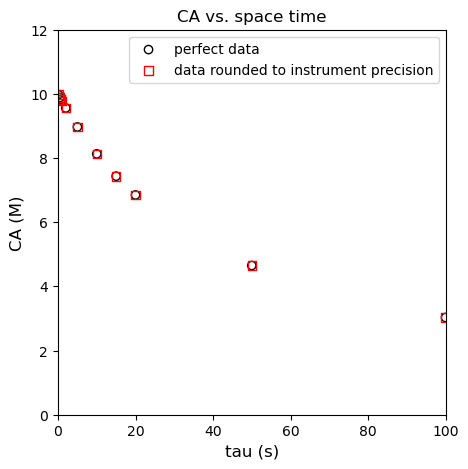

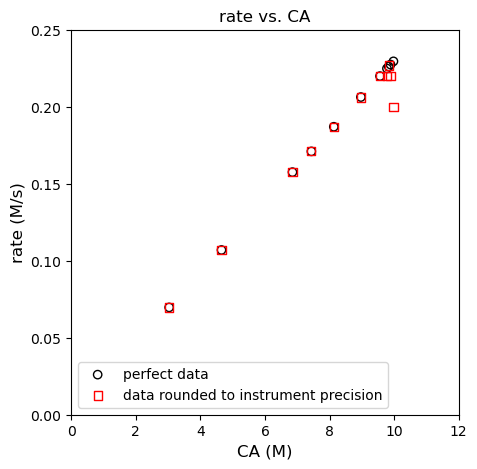

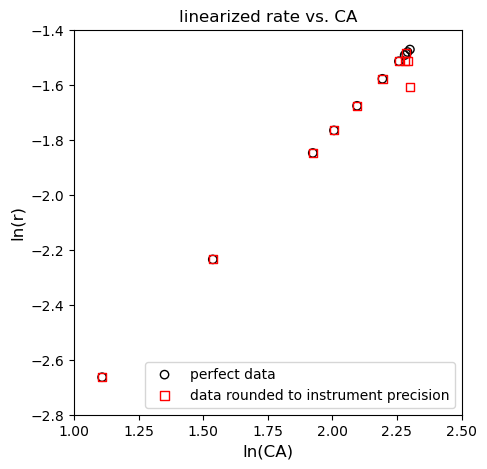

array([[ 9.977e+00,  9.980e+00, -3.000e-02],
       [ 9.886e+00,  9.890e+00, -3.700e-02],
       [ 9.830e+00,  9.830e+00,  4.000e-03],
       [ 9.775e+00,  9.780e+00, -4.900e-02],
       [ 9.560e+00,  9.560e+00,  2.000e-03],
       [ 8.969e+00,  8.970e+00, -1.500e-02],
       [ 8.130e+00,  8.130e+00,  1.000e-03],
       [ 7.435e+00,  7.430e+00,  6.600e-02],
       [ 6.849e+00,  6.850e+00, -1.000e-02],
       [ 4.651e+00,  4.650e+00,  2.500e-02],
       [ 3.030e+00,  3.030e+00,  1.000e-02]])

array([[ 2.2900e-01,  2.0000e-01,  1.2843e+01],
       [ 2.2700e-01,  2.2000e-01,  3.2480e+00],
       [ 2.2600e-01,  2.2700e-01, -2.6000e-01],
       [ 2.2500e-01,  2.2000e-01,  2.1480e+00],
       [ 2.2000e-01,  2.2000e-01, -5.2000e-02],
       [ 2.0600e-01,  2.0600e-01,  1.3500e-01],
       [ 1.8700e-01,  1.8700e-01, -4.0000e-03],
       [ 1.7100e-01,  1.7100e-01, -1.7500e-01],
       [ 1.5800e-01,  1.5800e-01,  2.2000e-02],
       [ 1.0700e-01,  1.0700e-01, -2.2000e-02],
       [ 7.0000e-02,  7.0000e-02, -4.0000e-03]])

In [35]:
V      = 0.275 #L
CAf    = 10    #mol/L
Qfdata = np.array([2.75, 0.55, 0.3667, 0.275, 0.1375, 0.055, 0.0275, 0.01833, 0.01375, 0.0055, 0.00275]) #mol/L
CAdata = np.array([9.98, 9.89, 9.83, 9.78, 9.56, 8.97, 8.13, 7.43, 6.85, 4.65, 3.03]) #L/sec
τdata  = V/Qfdata
rdata  = (CAf - CAdata)/τdata

plt.figure(figsize = (5, 5))
plt.scatter(τtrue, CAtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(τdata, CAdata, marker = 's', color = 'none', edgecolor = 'red', label = 'data rounded to instrument precision')
plt.xlabel('tau (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 100)
plt.ylim(0, 12)
plt.title('CA vs. space time')
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(CAtrue, rtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(CAdata, rdata, marker = 's', color = 'none', edgecolor = 'red', label = 'data rounded to instrument precision')
plt.xlabel('CA (M)', fontsize = 12)
plt.ylabel('rate (M/s)', fontsize = 12)
plt.title('rate vs. CA')
plt.xlim(0, 12)
plt.ylim(0, 0.25)
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(np.log(CAtrue), np.log(rtrue), marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(np.log(CAdata), np.log(rdata), marker = 's', color = 'none', edgecolor = 'red', label = 'data rounded to instrument precision')
plt.xlabel('ln(CA)', fontsize = 12)
plt.ylabel('ln(r)', fontsize = 12)
plt.title('linearized rate vs. CA')
plt.xlim(1.0, 2.5)
plt.xticks(np.arange(1.0, 2.51, 0.25))
plt.ylim(-2.8, -1.4)
plt.legend()
plt.show()

display(np.round(np.vstack((CAtrue, CAdata, (CAtrue - CAdata)*100/CAtrue)).T, 3))
display(np.round(np.vstack((rtrue, rdata, (rtrue - rdata)*100/rtrue)).T, 3))

#### Linear Regression on Data Rounded to Instrument Precision

Just with rounding error, we can see some issues already starting to pop up here.  Data look mostly linear, except for at very high concentrations of A.  Let's run through the regression and see what we get back.

m    =  9.64e-01 +/- 7.77e-02
b    = -3.72e+00 +/- 1.60e-01
SSE  =      0.02
SST  =      1.37
MSE  =      0.00
RMSE =      0.04
R2   =      0.99
α    =  9.64e-01 +/- 7.77e-02
k    =  2.43e-02 (but is between 2.07e-02 and 2.85e-02)


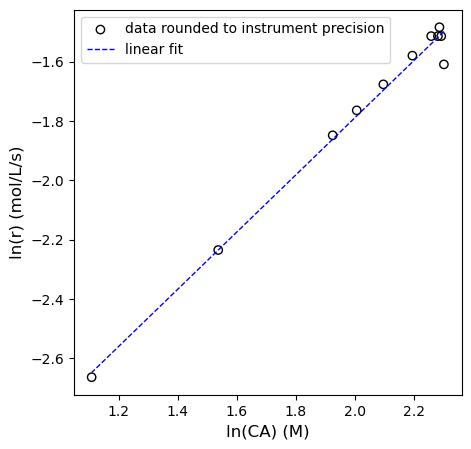

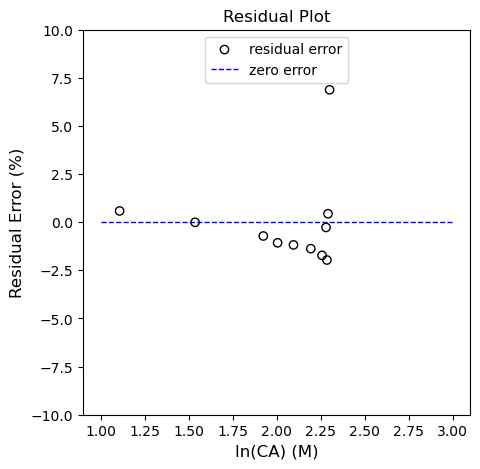

In [36]:
xdata = np.log(CAdata)
ydata = np.log(rdata)

X     = np.vander(xdata, 2)#This creates the X matrix shown above, truncating at 1st order
Y     = ydata    
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                #slope of best fit line
b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
CIb   = SEb*tval              #95% confidence interval on y-intercept
α     = m
k     = np.exp(b)
labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2, α, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2e} +/- {CIb:8.2e}')
    elif label == 'α':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:9.2e} (but is between {np.exp(b-CIb):8.2e} and {np.exp(b+CIb):8.2e})')
    else:
        print(f'{label:4s} = {value:9.2f}')
        
plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'data rounded to instrument precision')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('ln(CA) (M)', fontsize = 12)
plt.ylabel('ln(r) (mol/L/s)', fontsize = 12)
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('ln(CA) (M)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.ylim(-10, 10)
plt.legend(loc = 'upper center')
plt.show()

#### Adding Noise to the Data (simulating a real experiment)

Now we are going to make this data resemble something we'd get in a lab by adding some random noise.  This is gaussian noise (I'm adding a random number taken from a gaussian distribution with a given standard deviation).  For now, we'll look at how that impacts our measurments and the rates that we estimate from those measurements.

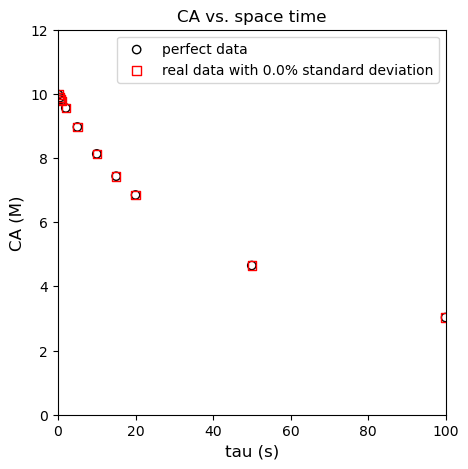

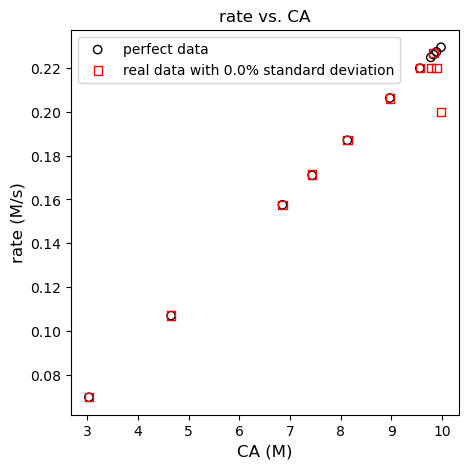

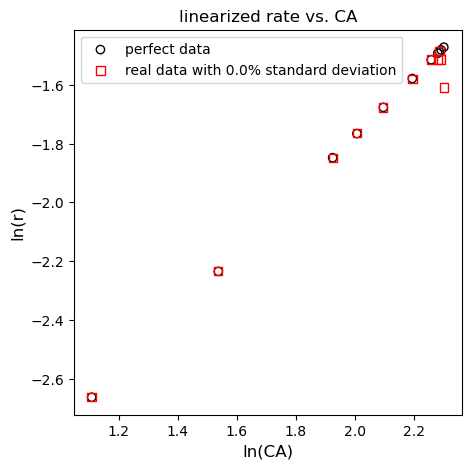

array([[ 9.97705278e+00,  9.98000000e+00, -2.95400001e-02],
       [ 9.88630746e+00,  9.89000000e+00, -3.73499996e-02],
       [ 9.83042517e+00,  9.83000000e+00,  4.32500012e-03],
       [ 9.77517107e+00,  9.78000000e+00, -4.93999999e-02],
       [ 9.56022945e+00,  9.56000000e+00,  2.39999993e-03],
       [ 8.96860987e+00,  8.97000000e+00, -1.54999997e-02],
       [ 8.13008130e+00,  8.13000000e+00,  9.99999840e-04],
       [ 7.43494424e+00,  7.43000000e+00,  6.64999998e-02],
       [ 6.84931507e+00,  6.85000000e+00, -9.99999990e-03],
       [ 4.65116279e+00,  4.65000000e+00,  2.50000000e-02],
       [ 3.03030303e+00,  3.03000000e+00,  9.99999990e-03]])

array([[ 2.2900e-01,  2.0000e-01,  1.2843e+01],
       [ 2.2700e-01,  2.2000e-01,  3.2480e+00],
       [ 2.2600e-01,  2.2700e-01, -2.6000e-01],
       [ 2.2500e-01,  2.2000e-01,  2.1480e+00],
       [ 2.2000e-01,  2.2000e-01, -5.2000e-02],
       [ 2.0600e-01,  2.0600e-01,  1.3500e-01],
       [ 1.8700e-01,  1.8700e-01, -4.0000e-03],
       [ 1.7100e-01,  1.7100e-01, -1.7500e-01],
       [ 1.5800e-01,  1.5800e-01,  2.2000e-02],
       [ 1.0700e-01,  1.0700e-01, -2.2000e-02],
       [ 7.0000e-02,  7.0000e-02, -4.0000e-03]])

In [37]:
noise_level = 0.0 #percent standard deviation on the mean.
np.random.seed(ceil(noise_level))
V       = 0.275 #L
CAf     = 10    #mol/L
Qfdata  = np.array([2.75, 0.55, 0.3667, 0.275, 0.1375, 0.055, 0.0275, 0.01833, 0.01375, 0.0055, 0.00275]) #mol/L
CAdata  = np.array([9.98, 9.89, 9.83, 9.78, 9.56, 8.97, 8.13, 7.43, 6.85, 4.65, 3.03]) #L/sec
τdata   = V/Qfdata
noise   = CAdata*np.random.normal(0, noise_level/100, CAdata.shape)
CAdatan = CAdata + noise

rdata   = (CAf - CAdata)/τdata
rdatan  = (CAf - CAdatan)/τdata

plt.figure(figsize = (5, 5))
plt.scatter(τtrue, CAtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(τdata, CAdatan, marker = 's', color = 'none', edgecolor = 'red', label = f'real data with {noise_level}% standard deviation')
plt.xlabel('tau (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 100)
plt.ylim(0, 12)
plt.title('CA vs. space time')
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(CAtrue, rtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(CAdatan, rdatan, marker = 's', color = 'none', edgecolor = 'red', label = f'real data with {noise_level}% standard deviation')
plt.xlabel('CA (M)', fontsize = 12)
plt.ylabel('rate (M/s)', fontsize = 12)
plt.title('rate vs. CA')
#plt.xlim(0, 12)
#plt.ylim(0, 0.4)
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(np.log(CAtrue), np.log(rtrue), marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(np.log(CAdatan), np.log(rdatan), marker = 's', color = 'none', edgecolor = 'red', label = f'real data with {noise_level}% standard deviation')
plt.xlabel('ln(CA)', fontsize = 12)
plt.ylabel('ln(r)', fontsize = 12)
plt.title('linearized rate vs. CA')
plt.legend()
plt.show()

display(np.vstack((CAtrue, CAdatan, (CAtrue - CAdatan)*100/CAtrue)).T)
display(np.round(np.vstack((rtrue, rdatan, (rtrue - rdatan)*100/rtrue)).T, 3))

m    =  9.64e-01 +/- 7.77e-02
b    = -3.72e+00 +/- 1.60e-01
SSE  =      0.02
SST  =      1.37
MSE  =      0.00
RMSE =      0.04
R2   =      0.99
α    =  9.64e-01 +/- 7.77e-02
k    =  2.43e-02 (but is between 2.07e-02 and 2.85e-02)


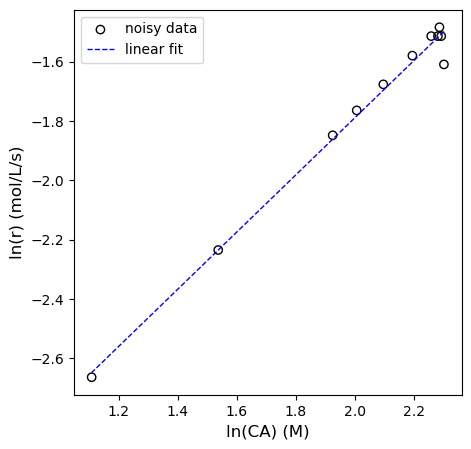

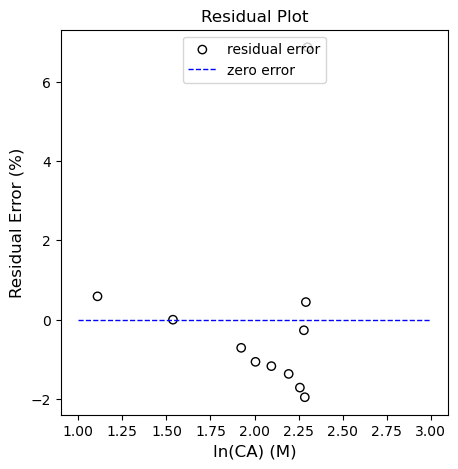

In [38]:
xdata = np.log(CAdatan)
ydata = np.log(rdatan)

X     = np.vander(xdata, 2)#This creates the X matrix shown above, truncating at 1st order
Y     = ydata    
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                #slope of best fit line
b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
CIb   = SEb*tval              #95% confidence interval on y-intercept
α     = m
k     = np.exp(b)
labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2, α, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2e} +/- {CIb:8.2e}')
    elif label == 'α':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:9.2e} (but is between {np.exp(b-CIb):8.2e} and {np.exp(b+CIb):8.2e})')
    else:
        print(f'{label:4s} = {value:9.2f}')
        
plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'noisy data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('ln(CA) (M)', fontsize = 12)
plt.ylabel('ln(r) (mol/L/s)', fontsize = 12)
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('ln(CA) (M)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper center')
plt.show()

The problem above isn't in our logic or in our math...it's in our precision, specifically the ability to measure concentrations in the laboratory.  Consider our definition of the rate in this CSTR as we've defined it so far.  It is based on measuring the change in the concentration of species A relative to the feed at a given residence time:

$$r = \frac{C_{Af} - C_A}{\tau}$$

If we go to residence times near zero, then our fractional conversion goes to zero (consider that $X_A = r\tau/C_{Af}$).  In the limit of zero conversion, then:

$$C_{Af} \approx C_A$$

Measuring precise changes in the concentration of reactant as the conversion of that reactant approaches zero is very difficult.  It only takes a bit of uncertainty in our measurements before we're getting results like $C_A > C_{Af}$ for very small values of $\tau$.  Physically, that's impossible for this reaction, but our limits on precision make it something we have to contend with.  When we're in this situation of trying to determine reaction rates at nearly zero conversion, the better approach is to do this based on a balance on our product:

$$0 = C_{Bf} - C_B + R_B\tau$$

Since $R_B = r$, this can be solved to give:

$$r = \frac{C_B}{\tau}$$

Now, we're basically measuring the change in concentration of species B relative to zero (the inlet concentration of B).  Those measurements are still subject to the usual uncertainty, but we'll see that the reaction rates we estimate are far more precise in the limit of zero conversion.

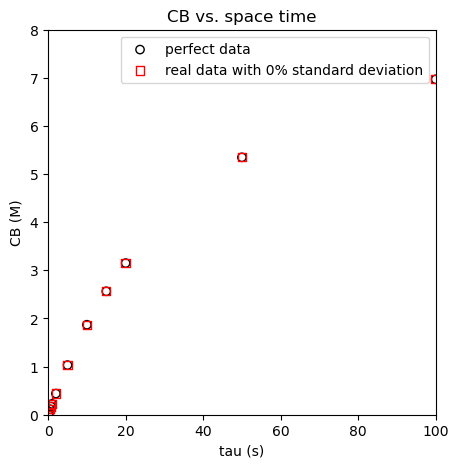

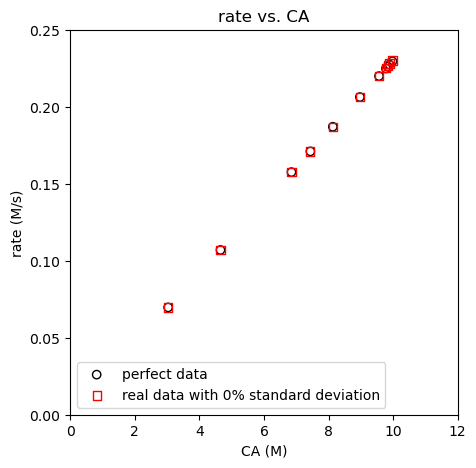

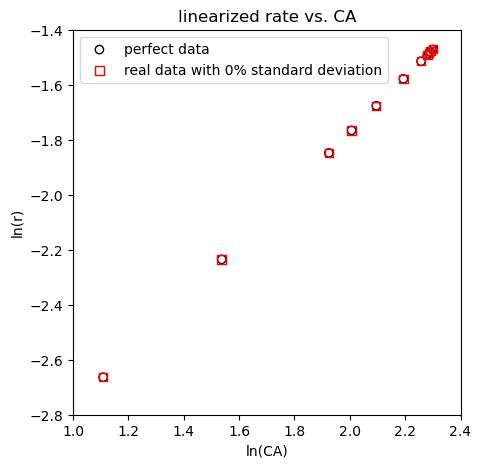

array([[ 2.29472210e-02,  2.30000000e-02, -2.30001707e-01],
       [ 1.13692536e-01,  1.14000000e-01, -2.70434640e-01],
       [ 1.69574834e-01,  1.70000000e-01, -2.50724704e-01],
       [ 2.24828935e-01,  2.25000000e-01, -7.60867368e-02],
       [ 4.39770554e-01,  4.40000000e-01, -5.21740253e-02],
       [ 1.03139014e+00,  1.03100000e+00,  3.78261326e-02],
       [ 1.86991870e+00,  1.87000000e+00, -4.34783609e-03],
       [ 2.56505576e+00,  2.56500000e+00,  2.17390986e-03],
       [ 3.15068493e+00,  3.15100000e+00, -9.99998435e-03],
       [ 5.34883721e+00,  5.34900000e+00, -3.04348391e-03],
       [ 6.96969697e+00,  6.97000000e+00, -4.34782174e-03]])

array([[ 0.22947221,  0.23      , -0.23000171],
       [ 0.22738507,  0.228     , -0.27043464],
       [ 0.22609978,  0.22668727, -0.2598384 ],
       [ 0.22482894,  0.225     , -0.07608674],
       [ 0.21988528,  0.22      , -0.05217403],
       [ 0.20627803,  0.2062    ,  0.03782613],
       [ 0.18699187,  0.187     , -0.00434784],
       [ 0.17100372,  0.17096891,  0.02035515],
       [ 0.15753425,  0.15755   , -0.00999998],
       [ 0.10697674,  0.10698   , -0.00304348],
       [ 0.06969697,  0.0697    , -0.00434782]])

In [39]:
noise_level = 0 #percent standard deviation on the mean.
np.random.seed(ceil(noise_level))

V       = 0.275 #L
CAf     = 10    #mol/L
Qfdata  = np.array([2.75, 0.55, 0.3667, 0.275, 0.1375, 0.055, 0.0275, 0.01833, 0.01375, 0.0055, 0.00275]) #mol/L
CAdata  = np.array([9.98, 9.89, 9.83, 9.78, 9.56, 8.97, 8.13, 7.43, 6.85, 4.65, 3.03]) #L/sec
CBtrue  = np.array([0.022947221, 0.113692536, 0.169574834, 0.224828935, 0.439770554, 1.031390135, 1.869918699, 2.565055762, 3.150684932, 5.348837209, 6.96969697]) 
τdata   = V/Qfdata
CBdata  = np.round(CBtrue, 3)
noise   = CBdata*np.random.normal(0, noise_level/100, CBdata.shape)
CBdatan = CBdata + noise

noiseA  = CAdata*np.random.normal(0, noise_level/100, CAdata.shape)
CAdatan = CAdata + noiseA

rbtrue  = CBtrue/τtrue
rbdatan  = (CBdatan)/τdata

plt.figure(figsize = (5, 5))
plt.scatter(τtrue, CBtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(τdata, CBdatan, marker = 's', color = 'none', edgecolor = 'red', label = f'real data with {noise_level}% standard deviation')
plt.xlabel('tau (s)')
plt.ylabel('CB (M)')
plt.title('CB vs. space time')
plt.xlim(0, 100)
plt.ylim(0, 8)
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(CAtrue, rbtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(CAdatan, rbdatan, marker = 's', color = 'none', edgecolor = 'red', label = f'real data with {noise_level}% standard deviation')
plt.xlabel('CA (M)')
plt.ylabel('rate (M/s)')
plt.title('rate vs. CA')
plt.xlim(0, 12)
plt.ylim(0, 0.25)
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(np.log(CAtrue), np.log(rbtrue), marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(np.log(CAdatan), np.log(rbdatan), marker = 's', color = 'none', edgecolor = 'red', label = f'real data with {noise_level}% standard deviation')
plt.xlabel('ln(CA)')
plt.ylabel('ln(r)')
plt.title('linearized rate vs. CA')
plt.xlim(1.0, 2.4)
plt.ylim(-2.8, -1.4)
plt.legend()
plt.show()

display(np.vstack((CBtrue, CBdatan, (CBtrue - CBdatan)*100/CBtrue)).T)
display(np.vstack((rbtrue, rbdatan, (rbtrue - rbdatan)*100/rbtrue)).T)

m    =  1.00e+00 +/- 1.91e-03
b    = -3.77e+00 +/- 3.92e-03
SSE  =      0.00
SST  =      1.46
MSE  =      0.00
RMSE =      0.00
R2   =      1.00
α    =  1.00e+00 +/- 1.91e-03
k    =  2.30e-02 (but is between 2.29e-02 and 2.31e-02)


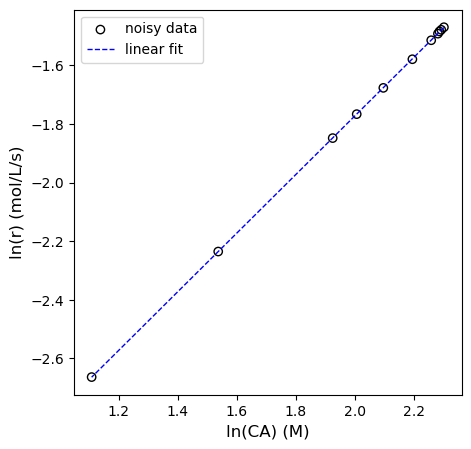

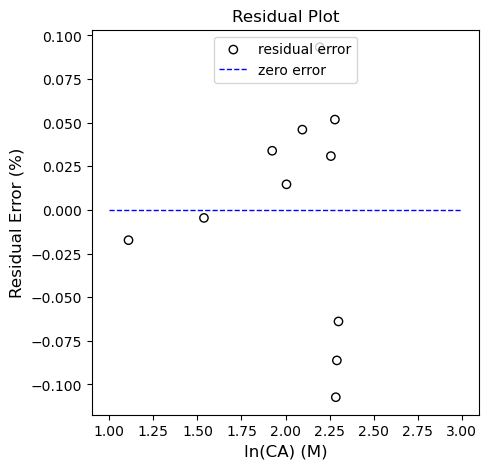

In [40]:
xdata = np.log(CAdatan)
ydata = np.log(rbdatan)

X     = np.vander(xdata, 2)#This creates the X matrix shown above, truncating at 1st order
Y     = ydata    
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                #slope of best fit line
b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
CIb   = SEb*tval              #95% confidence interval on y-intercept
α     = m
k     = np.exp(b)
labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2, α, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2e} +/- {CIb:8.2e}')
    elif label == 'α':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:9.2e} (but is between {np.exp(b-CIb):8.2e} and {np.exp(b+CIb):8.2e})')
    else:
        print(f'{label:4s} = {value:9.2f}')
        
plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'noisy data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('ln(CA) (M)', fontsize = 12)
plt.ylabel('ln(r) (mol/L/s)', fontsize = 12)
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('ln(CA) (M)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper center')
plt.show()

## Example Problem 02

We next consider a data set where not much has been done systematically. Someone decided to perform a "kinetic study" of the following reaction in a CSTR.

$$A + 2B \longrightarrow 3C$$

We propose that the rate of reaction depends on concentrations of A and B in some power law model:

$$r = kC_A^\alpha C_B^\beta$$

We want to estimate $k$, $\alpha$, and $\beta$.  Our conventional wisdom is that, to determine a parameter, you need to vary the quantity influenced that parameter while holding everything else constant.  For example, if you wanted to know $\alpha$, the most straightforward experiment would be one that measures $r$ for various values of $C_A$ while holding $C_B$ constant.  This would allow you to isolate the impact of $C_A$ on reaction rate and therefore estimate $\alpha$.  

Here our experimentalist made some interesting choices in how they ran the experiment.  They varied space time (by varying feed flowrate), and they also seem to have been randomly changing the feed concentrations of both A and B with every change in residence time. We'd love to get an estimate for k, $\alpha$, and $\beta$, but it isn't quite clear how we would do that based on the data available.

The data are in an attached CSV file.  

### Importing into a dataframe with pandas

The code in the cell below will import the data as a dataframe, which has the display characteristics of a table or spreadsheet; we are doing this just to see the data that we hav eon hand: it includes residence times ($\tau$); feed concentrations of A, B, and C ($C_{Af}$ and $C_{Bf}$); and fractional conversion of A measured at at the reactor exit.

In [41]:
import pandas as pd
dataframe = pd.read_csv("CSTRDATA32.csv")
dataframe;

### Importing data as a numpy array

The cell below uses Python's csv reader to parse the input file (CSTRdata.csv).  It stores the information in an array called "data".

In [42]:
import csv
labels    = ['r (mol/L/min)']
file      = open("CSTRDATA32.csv")
csvreader = csv.reader(file)
header    = []
header    = next(csvreader)
for value in labels:
    header.append(value)
rows      = []
for row in csvreader:
    rows.append(row)
file.close()
data = np.array(rows, dtype = 'float')
data;

### Parameter Estimation Using Nonlinear Regression

One solution is to use nonlinear regression to minimize an objective function created by calculating the residual sum of squares between measured rates and model predicted rates.  Example below

In [43]:
taudata   = data[:, 0]
CAfdata   = data[:, 1]
CBfdata   = data[:, 2]
CCfdata   = data[:, 3]
XAdata    = data[:, 4]
CAdata    = data[:, 5]
CBdata    = data[:, 6]
CCdata    = data[:, 7]

In [44]:
rdata     = CCdata/3/taudata
data_all  = np.hstack([data, rdata.reshape(len(rdata), 1)])
data_all
dataframe = pd.DataFrame(data_all, columns = header)
dataframe

,tau (min),Caf (mol/L),CBf (mol/L),CCf (mol/L),XA,CA (mol/L),CB (mol/L),CC (mol/L),r (mol/L/min)
0,34.877,0.40,1.55,0.0,0.894,0.042,0.824,1.077,0.010293
1,0.103,0.83,2.38,0.0,0.141,0.727,2.209,0.366,1.184466
2,0.646,0.27,1.00,0.0,0.158,0.218,0.923,0.118,0.060888
3,0.923,0.68,2.16,0.0,0.439,0.392,1.507,0.846,0.305525
4,0.217,0.39,0.94,0.0,0.057,0.362,0.806,0.061,0.093702
5,8.653,0.68,1.56,0.0,0.613,0.246,0.753,1.371,0.052814
6,36191.127,0.06,0.13,0.0,0.881,0.007,0.025,0.170,0.000002
7,0.774,0.40,1.42,0.0,0.278,0.296,1.125,0.363,0.156331
8,423.825,0.10,0.34,0.0,0.820,0.018,0.188,0.254,0.000200
9,8.683,0.22,0.85,0.0,0.533,0.098,0.605,0.366,0.014050


In [45]:
def rates_CSTR(par, meas):
    k     = par[0]
    alpha = par[1]
    beta  = par[2]
    
    CA  = meas[:, 5]
    CB  = meas[:, 6]
    
    rmod = k*CA**alpha*CB**beta
    return rmod

par0 = [1, 1,1]
rates_CSTR(par0, data_all)
OBJ  = lambda par: np.sum((rates_CSTR(par, data_all) - rdata)**2)
ans  = opt.minimize(OBJ, par0)
k_opt, α_opt, β_opt = ans.x
print(f' k = {k_opt:8.2E}, α = {α_opt:3.2f}, β = {β_opt:3.2f}')

 k = 3.02E-01, α = 0.99, β = 2.22


### Multiple Linear Regression

Alternatively, we can linearize this problem.  We know that the rate of reaction should be given by a power law:

$$r = k{C_A}^\alpha {C_B}^\beta$$

This can be linearized as usual by taking logarithms of both sides to give:

$$\ln(r) = \alpha \ln(C_A) + \beta \ln(C_B) + \ln(k)$$

Putting this into matrix form, we would have:

$$XA = Y$$

Where

X is a vandermonde type matrix in which each row is:

$$X[i,:] = \begin{bmatrix} \ln(C_A)_i & \ln(C_B)_i & 1 \end{bmatrix}$$ 

Where

$$A = \begin{bmatrix} \alpha \\ \beta \\ \ln(k) \end{bmatrix}$$

And where Y is a vector of our measurements, in this case, ln(r), so each entry is given by:

$$Y[i] = \ln(r)_i$$

With those definitions, we can perform linear regression as usual.  Below, I create the X matrix manually because I don't know offhand of an automated way to generate the X matrix for multiple linear regression.  Once that is done, you solve the least squares problem as usual:

$$\hat{A} = (X^\prime X)^{-1}X^\prime Y$$

ln(k) = -1.064 plus/minus 0.2621
SSE  =      0.26
SST  =    328.06
MSE  =      0.02
RMSE =      0.15
R2   =      1.00
α    =  9.93e-01 +/- 1.72e-01
β    =  2.03e+00 +/- 2.00e-01
k    =  3.45e-01 (but is between 2.65e-01 and 4.48e-01)


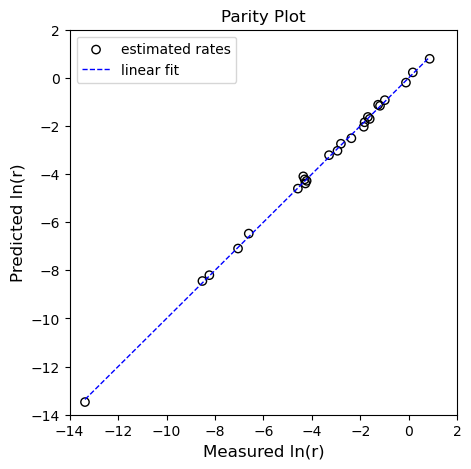

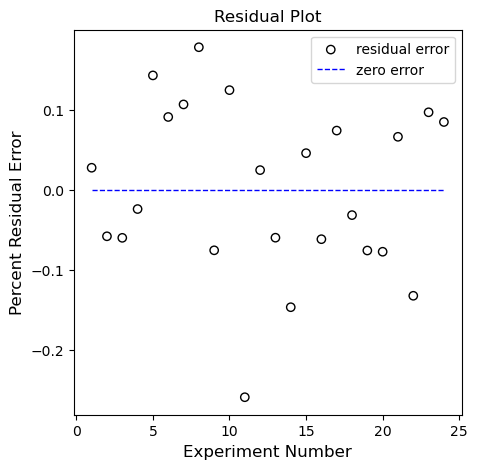

In [50]:
X      = np.ones((len(rdata),3))
X[:,0] = np.log(CAdata)
X[:,1] = np.log(CBdata)
Y      = np.log(rdata)
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
α     = A[0]                #slope of best fit line
β     = A[1]                  #y-intercept of best fit line
b     = A[2]
SEα   = np.sqrt(COV[0, 0])    #Standard error in α
SEβ   = np.sqrt(COV[1, 1])    #Standard error in β
SEb   = np.sqrt(COV[2, 2])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIα   = SEα*tval              #95% confidence interval on α
CIβ   = SEβ*tval              #95% confidence interval on β
CIb   = SEb*tval              #95% confidence interval on y-intercept
k     = np.exp(b)
labels = ['SSE', 'SST','MSE','RMSE', 'R2', 'α', 'β', 'k']
values = [ SSE ,  SST , MSE , RMSE ,  R2 ,  α ,  β ,  k ]

print(f'ln(k) = {A[2]:3.3f} plus/minus {CIb:3.4f}')

for label, value in zip(labels, values):
    if label == 'α':
        print(f'{label:4s} = {value:9.2e} +/- {CIα:8.2e}')
    elif label == 'β':
        print(f'{label:4s} = {value:9.2e} +/- {CIβ:8.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2e} +/- {CIb:8.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:9.2e} (but is between {np.exp(b-CIb):8.2e} and {np.exp(b+CIb):8.2e})')
    else:
        print(f'{label:4s} = {value:9.2f}')
        
plt.figure(1, figsize = (5, 5))
plt.scatter(Y, Ypred, marker = 'o', color = 'none', edgecolor = 'black', label = 'estimated rates')
plt.plot([min(Y), max(Y)], [min(Y), max(Y)], color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('Measured ln(r)', fontsize = 12)
plt.ylabel('Predicted ln(r)', fontsize = 12)
plt.title('Parity Plot')
plt.xlim(-14.0, 2.0)
plt.ylim(-14.0, 2.0)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(np.arange(1, len(Y)+1, 1), (Y - Ypred), marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, 1, len(Y), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('Experiment Number', fontsize = 12)
plt.ylabel('Percent Residual Error', fontsize = 12)
plt.title('Residual Plot')
#plt.xlim(-14.0, 2.0)
#plt.ylim(-14.0, 2.0)
plt.legend()
plt.show()
